# Mediation & Moderation Analysis

In [5]:
!pip install -q --upgrade pyreadstat

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import missingno as msno
import statsmodels.api as sm

## Preprocessing

In [7]:
df = pd.read_spss("data.sav")
df

ID City    Town   V4    V5  ... sex      AGE    EDU arear         w
0     1.020802e+12  宜蘭縣  宜蘭縣冬山鄉  很重要   很重要  ...  男性   18至29歲   高中、職   宜花東  0.378858
1     1.020802e+12  宜蘭縣  宜蘭縣冬山鄉  很重要  還算重要  ...  女性   30至39歲   高中、職   宜花東  0.472462
2     1.020802e+12  宜蘭縣  宜蘭縣冬山鄉  很重要  還算重要  ...  女性   40至49歲   國、初中   宜花東  0.486884
3     1.020802e+12  宜蘭縣  宜蘭縣冬山鄉  很重要   很重要  ...  男性   50至59歲   高中、職   宜花東  0.372428
4     1.020802e+12  宜蘭縣  宜蘭縣冬山鄉  很重要  還算重要  ...  男性   18至29歲   高中、職   宜花東  0.378858
...            ...  ...     ...  ...   ...  ...  ..      ...    ...   ...       ...
1233  4.673201e+12  台南市   台南市東區  很重要  還算重要  ...  男性  60歲至85歲   國、初中   雲嘉南  0.751821
1234  4.673203e+12  台南市   台南市東區  很重要   很重要  ...  女性  60歲至85歲   高中、職   雲嘉南  0.648197
1235  4.673203e+12  台南市   台南市東區  很重要  還算重要  ...  女性   40至49歲   國、初中   雲嘉南  0.904065
1236  4.673301e+12  台南市   台南市南區  很重要   很重要  ...  女性   50至59歲  小學及以下   雲嘉南  0.597744
1237  4.673301e+12  台南市   台南市南區  很重要  不太重要  ...  女性   30至39歲   高中、職   雲嘉南  0.877285

[1238 rows x 309 columns]

In [8]:
df = pd.read_spss("data.sav")
vb_list = ['sex', 'V238', 'V239', 'EDU', 'V242', 'V57', 'V55', 'V23', 'V100',
           'V84', 'V98', 'V212', 'V213', 'V214', 'V215', 'V216', 'V95', 'V211', 
           'V144', 'V147', 'V149', 'V73', 'V74', 'V143', 'V207', 'V207A']
df = df.loc[:, vb_list]
transform_dict = {"V238":"soc_class","V239":"income","EDU":"edu","V242":"age",
                  "V242":"age","V57":"marriage_status","V55":"controllability", 
                  "V23":"satisfaction","V100":"deligence",
                  "V84":"political_enthusiasm","V98":"national_responsibility",
                  "V212":"belonging_world","V213":"belonging_community","V214":"belonging_Taiwan",
                  "V215":"belonging_Asia","V216":"individuality","V95":"left_right_spectrum",
                  "V211":"nationalism","V144":"religion", "V147":"devotionality",
                  "V149":"view_on_hell","V73":"hedonism","V74":"altruism","V143":"existentialism",
                  "V207":"view_on_suicide","V207A":"view_on_euthanasia"} 
df.rename(columns = transform_dict, inplace = True)

In [9]:
df.drop(df[df['nationalism']=="我不是台灣的人民"].index, inplace = True)

In [10]:
for i in df.columns:
  df[i] = df[i].cat.add_categories('Missing')
  df.fillna({i:"Missing"}, inplace = True)

In [11]:
df["sex"] = df["sex"].replace({'女性':'female', '男性':'male'}).astype("category")
df["soc_class"] = df["soc_class"].replace({'上層階級':1, '中上階級':2, '中下階級':3, '勞工階級':4, '下層階級':5, 'Missing':np.nan}).astype("float")
df['income'] = df['income'].replace({'最低':'1', '最高':'10', 'Missing':np.nan}).astype("float")
df["edu"] = df["edu"].replace({'國、初中':2, '大學及以上':5, '專科':4, '小學及以下':1, '高中、職':3, 'Missing':np.nan}).astype("float")
df["age"] = df["age"].replace({'Missing':np.nan}).astype("float")
df["marriage_status"] = df["marriage_status"].replace({'分居':'seperated', '同居':'cohabitation', '喪偶':'widowed', '單身（從未結過婚）':'single', '已婚':'married', '離婚':'divorced', 'Missing':np.nan}).astype("category")
df['controllability'] = df['controllability'].replace({'完全沒選擇權':'1', '有很大的選擇權':'10', 'Missing':np.nan}).astype("float")
df['satisfaction'] = df['satisfaction'].replace({'非常不滿意':'1', '非常滿意':'10', 'Missing':np.nan}).astype("float")
df['deligence'] = df['deligence'].replace({"長期而言，努力工作通常會帶來較好的生活":1, "努力工作通常不會帶來成功，更重要的是運氣和人際關係":10, 'Missing':np.nan}).astype("float")

df["political_enthusiasm"] = df["political_enthusiasm"].replace({'一點也不感興趣':1, '不太感興趣':2, '很感興趣':3, '有點興趣':4, 'Missing':np.nan}).astype("float")
df["national_responsibility"] = df["national_responsibility"].replace({"國家應該承擔更多責任來照顧每個人的生活":1, "個人應該承擔更多責任來養活自己":10, 'Missing':np.nan}).astype("float")
df["belonging_world"] = df["belonging_world"].replace({'非常不同意':1, '不同意':2, '同意':3, '非常同意':4, 'Missing':np.nan}).astype("float")
df["belonging_community"] = df["belonging_community"].replace({'非常不同意':1, '不同意':2, '同意':3, '非常同意':4, 'Missing':np.nan}).astype("float")
df["belonging_Taiwan"] = df["belonging_Taiwan"].replace({'非常不同意':1, '不同意':2, '同意':3, '非常同意':4, 'Missing':np.nan}).astype("float")
df["belonging_Asia"] = df["belonging_Asia"].replace({'非常不同意':1, '不同意':2, '同意':3, '非常同意':4, 'Missing':np.nan}).astype("float")
df["individuality"] = df["individuality"].replace({'非常不同意':1, '不同意':2, '同意':3, '非常同意':4, 'Missing':np.nan}).astype("float")
df["left_right_spectrum"] = df["left_right_spectrum"].replace({"極端左派":1, "極端右派":10, 'Missing':np.nan}).astype("float")
df["nationalism"] = df["nationalism"].replace({"一點也不自豪":1, '不太自豪':2, '自豪':3, '很自豪':4, 'Missing':np.nan}).astype("float")
df["religion"] = df["religion"].replace({"一貫道":"Yiguandao", "不屬於任何宗教":"Atheism", "佛教":"Buddhism", "基督教":"Protestant", "天主教":"Catholic", "民間信仰":"Folk Beliefs", "道教":"Taoism", "其他(2+3、3+7、4+7、6+7、2+6+7、密教、錫安教、都有接觸)":"Others", 'Missing':np.nan}).astype("category")
df["devotionality"] = df["devotionality"].replace({"無神論者":0, "信仰不很虔誠的人":1, "信仰虔誠的人":2, 'Missing':np.nan}).astype("float")
df["view_on_hell"] = df["view_on_hell"].replace({"不信":0, "信":1, 'Missing':np.nan}).astype("category")
df.loc[:, "hedonism":"altruism"] = df.loc[:, "hedonism":"altruism"].replace({'很像我':1, '像我':2, '有些像我':3, '只有一點像我':4, '不像我':5, '完全不像我':6, 'Missing':np.nan}).astype("float")
df["existentialism"] = df["existentialism"].replace({"從未":1, "很少":2, "有時":3, "經常":4, 'Missing':np.nan}).astype("float")
df.loc[:, "view_on_suicide":"view_on_euthanasia"] = df.loc[:, "view_on_suicide":"view_on_euthanasia"].replace({"根本沒道理":1, "總是有理":10, 'Missing':np.nan}).astype("float")

df.head()

sex  soc_class  ...  view_on_suicide  view_on_euthanasia
0    male        3.0  ...              2.0                 5.0
1  female        4.0  ...              1.0                10.0
2  female        4.0  ...              1.0                 3.0
3    male        3.0  ...              1.0                 3.0
4    male        3.0  ...              1.0                 1.0

[5 rows x 26 columns]

In [12]:
df.isnull().sum(axis=0)

sex                          0
soc_class                   63
income                      64
edu                          2
age                          8
marriage_status              3
controllability             36
satisfaction                22
deligence                   50
political_enthusiasm        17
national_responsibility     49
belonging_world             83
belonging_community         44
belonging_Taiwan            41
belonging_Asia              77
individuality               52
left_right_spectrum        109
nationalism                 71
religion                     9
devotionality               40
view_on_hell                97
hedonism                    38
altruism                    33
existentialism              37
view_on_suicide             50
view_on_euthanasia          70
dtype: int64

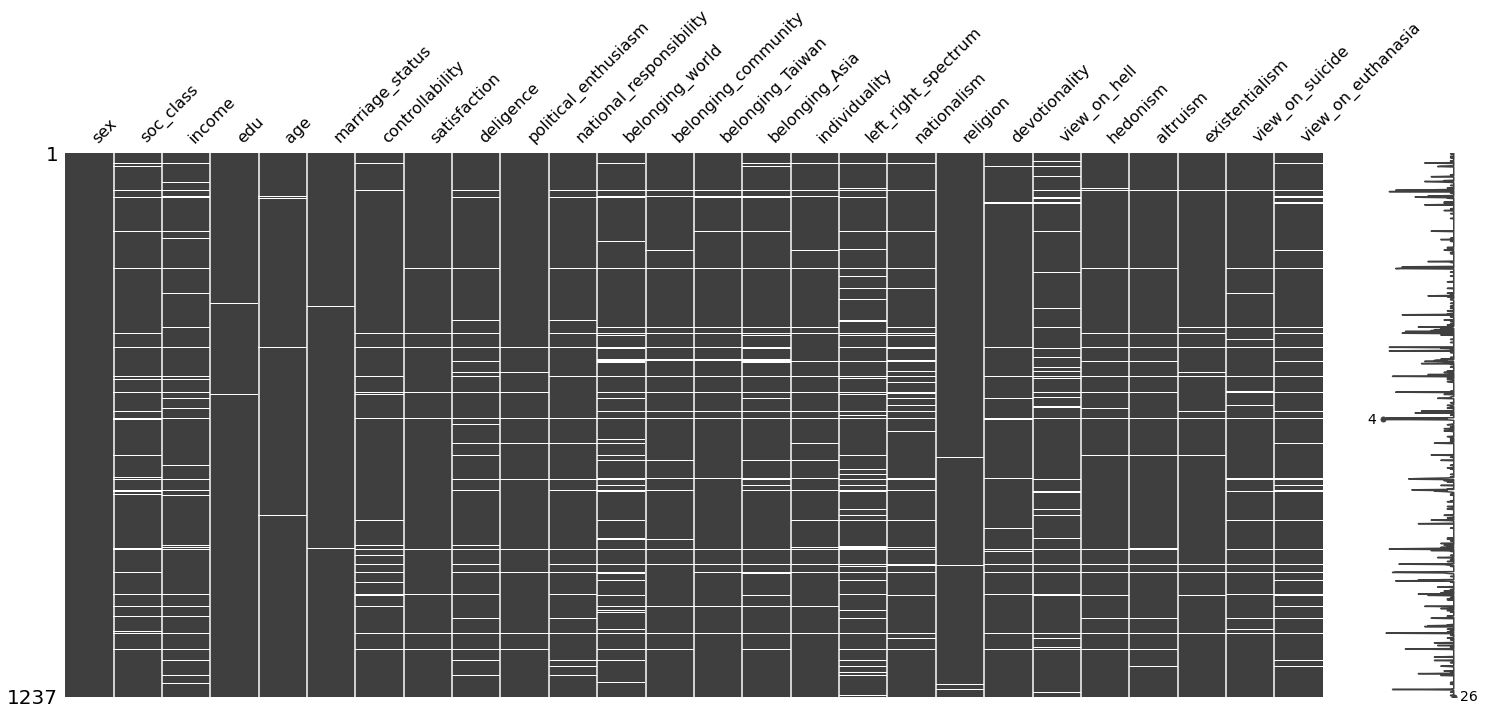

In [13]:
msno.matrix(df)

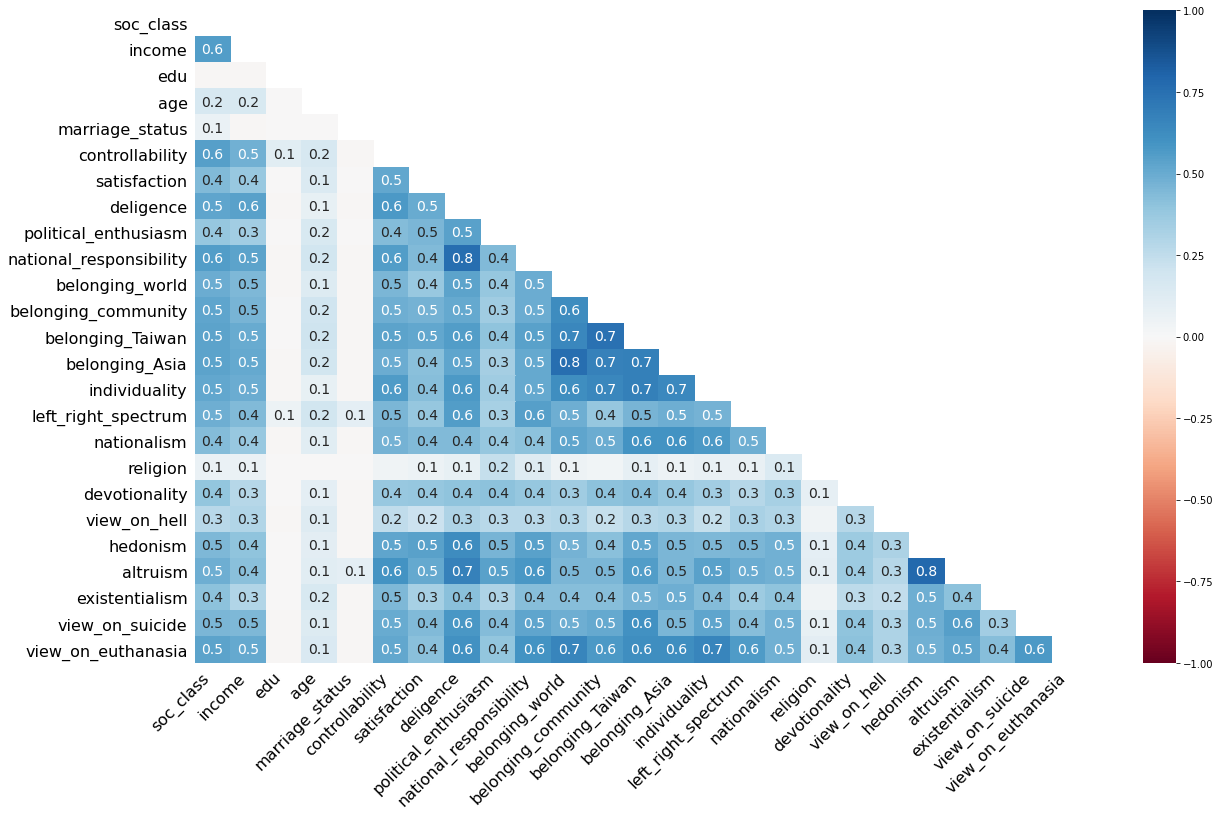

In [14]:
msno.heatmap(df)

In [15]:
df.dropna(inplace=True)

In [16]:
df

sex  soc_class  ...  view_on_suicide  view_on_euthanasia
0       male        3.0  ...              2.0                 5.0
1     female        4.0  ...              1.0                10.0
3       male        3.0  ...              1.0                 3.0
4       male        3.0  ...              1.0                 1.0
5     female        2.0  ...              1.0                 5.0
...      ...        ...  ...              ...                 ...
1231  female        3.0  ...              2.0                 8.0
1232  female        3.0  ...              5.0                 8.0
1233    male        4.0  ...              6.0                 8.0
1236  female        2.0  ...              1.0                 1.0
1237  female        4.0  ...              5.0                 5.0

[961 rows x 26 columns]

In [17]:
df_dummy = pd.get_dummies(data = df, columns = ["sex", "marriage_status", "religion"])

In [18]:
df_dummy.head()

soc_class  income  ...  religion_Taoism  religion_Yiguandao
0        3.0     6.0  ...                0                   0
1        4.0     5.0  ...                0                   0
3        3.0     4.0  ...                0                   0
4        3.0     5.0  ...                0                   0
5        2.0     5.0  ...                0                   0

[5 rows x 39 columns]

In [19]:
df_dummy.to_csv('df_lr.csv', index=False)

In [20]:
df_dummy_hinc = df_dummy[df_dummy['income'] >= 6]
df_dummy_linc = df_dummy[df_dummy['income'] <= 5]

In [21]:
df_dummy_hinc

soc_class  income  ...  religion_Taoism  religion_Yiguandao
0           3.0     6.0  ...                0                   0
10          3.0     7.0  ...                1                   0
13          2.0     6.0  ...                0                   0
14          2.0     6.0  ...                0                   0
17          3.0     6.0  ...                0                   0
...         ...     ...  ...              ...                 ...
1214        3.0     6.0  ...                0                   0
1217        2.0     7.0  ...                0                   0
1219        4.0     8.0  ...                0                   0
1228        2.0     6.0  ...                0                   0
1229        4.0     6.0  ...                0                   0

[327 rows x 39 columns]

In [22]:
df_dummy_linc

soc_class  income  ...  religion_Taoism  religion_Yiguandao
1           4.0     5.0  ...                0                   0
3           3.0     4.0  ...                0                   0
4           3.0     5.0  ...                0                   0
5           2.0     5.0  ...                0                   0
6           2.0     5.0  ...                0                   0
...         ...     ...  ...              ...                 ...
1231        3.0     3.0  ...                1                   0
1232        3.0     5.0  ...                0                   0
1233        4.0     3.0  ...                0                   0
1236        2.0     1.0  ...                0                   0
1237        4.0     5.0  ...                0                   0

[634 rows x 39 columns]

## Visualization

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5]),
 <a list of 38 Text major ticklabel objects>)

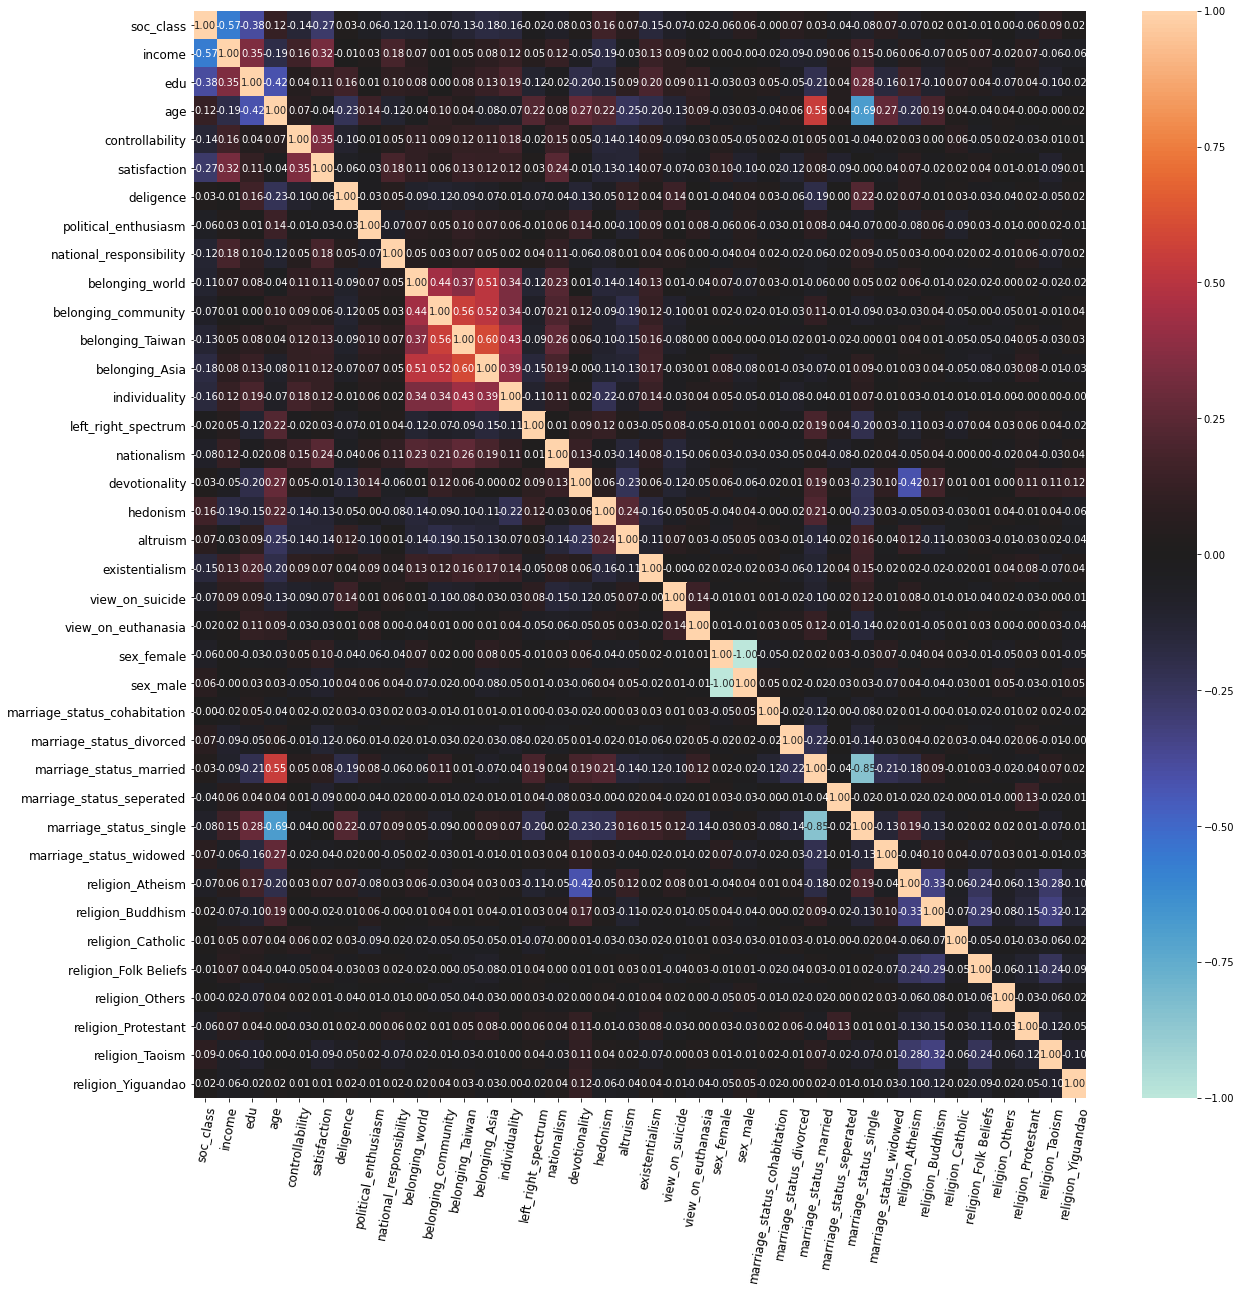

In [23]:
plt.figure(figsize=(20,20))
c= df_dummy.corr()
sns.heatmap(c, annot=True, fmt='.2f', cmap='icefire')
plt.xticks(size=12, rotation=80)
plt.yticks(size=12)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


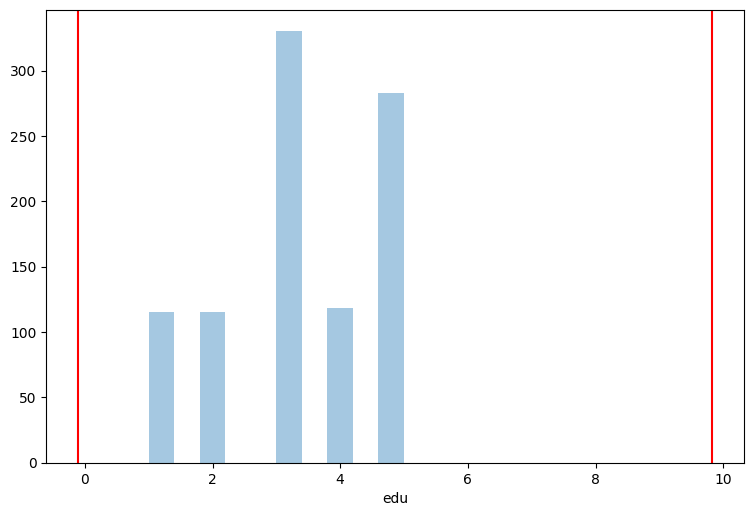

In [53]:
fig = plt.figure(figsize=(9,6), dpi = 100)
ax = sns.distplot(df_dummy["edu"], kde = False)
plt.axvline(x=np.mean(df_dummy["income"])-3 * np.std(df_dummy["income"]), color='r', linestyle='-')
plt.axvline(x=np.mean(df_dummy["income"])+3 * np.std(df_dummy["income"]), color='r', linestyle='-')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


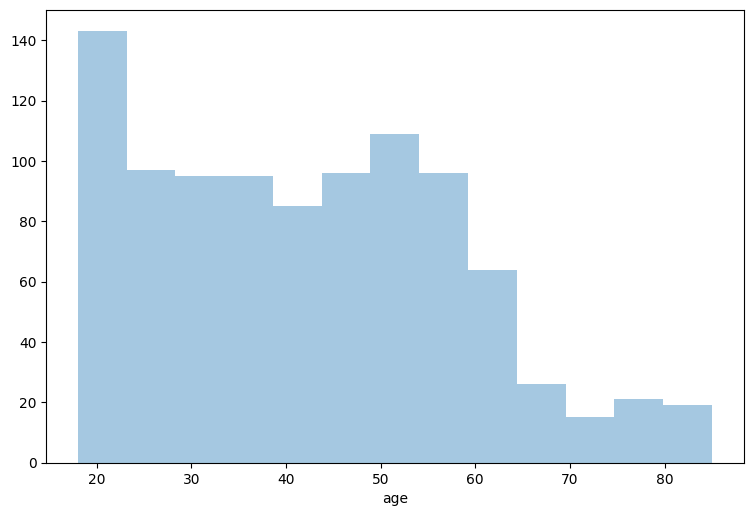

In [25]:
fig = plt.figure(figsize=(9,6), dpi = 100)
ax = sns.distplot(df_dummy["age"], kde = False)

In [42]:
df_dummy[df_dummy['age']>60]

soc_class  income  ...  religion_Taoism  religion_Yiguandao
6           2.0     5.0  ...                0                   0
7           4.0     5.0  ...                0                   0
22          2.0     6.0  ...                0                   1
25          4.0     3.0  ...                0                   0
34          5.0     1.0  ...                0                   0
...         ...     ...  ...              ...                 ...
1165        3.0     5.0  ...                0                   0
1180        4.0     5.0  ...                0                   0
1186        2.0     7.0  ...                0                   0
1214        3.0     6.0  ...                0                   0
1233        4.0     3.0  ...                0                   0

[125 rows x 39 columns]

In [65]:
alt.Chart(df_dummy).mark_bar().encode(
    alt.X('edu:N'),
    alt.Y('count():Q'),
    alt.Color('age:Q',bin=alt.BinParams(maxbins=5),scale=alt.Scale(scheme='magma'))
)

alt.Chart(...)

In [51]:
alt.Chart(df_dummy).mark_bar().encode(
    alt.X('individuality:Q',bin=alt.BinParams(maxbins=5)),
    alt.Y('age:Q',bin=alt.BinParams(maxbins=10)),
    alt.Color('count()',scale=alt.Scale(scheme='magma'))
)

alt.Chart(...)

In [45]:
df_dummy['altruism'] = 6 - df_dummy['altruism'] 

In [46]:
alt.Chart(df_dummy).mark_bar().encode(
    alt.X('age:Q',bin=alt.BinParams(maxbins=10)),
    alt.Y('altruism:Q',bin=alt.BinParams(maxbins=5)),
    alt.Color('count()',scale=alt.Scale(scheme='magma'))
)

alt.Chart(...)

In [48]:
alt.Chart(df_dummy).mark_bar().encode(
    alt.X('edu:Q',bin=alt.BinParams(maxbins=5)),
    alt.Y('altruism:Q',bin=alt.BinParams(maxbins=5)),
    alt.Color('count()',scale=alt.Scale(scheme='magma'))
)

alt.Chart(...)

In [49]:
df_dummy['individuality'] = 4 - df_dummy['individuality'] 

In [50]:
alt.Chart(df_dummy).mark_bar().encode(
    alt.X('individuality:Q',bin=alt.BinParams(maxbins=5)),
    alt.Y('altruism:Q',bin=alt.BinParams(maxbins=5)),
    alt.Color('count()',scale=alt.Scale(scheme='magma'))
)

alt.Chart(...)

## Moderation

In [29]:
np.median(df_dummy['income'])

5.0

In [30]:
heatmap = alt.Chart(df_dummy_linc).mark_bar().encode(
    alt.X('income:Q',bin=alt.BinParams(maxbins=6)),
    alt.Y('controllability:Q',bin=alt.BinParams(maxbins=5)),
    alt.Color('count()',scale=alt.Scale(scheme='magma'))
)

heatmap

alt.Chart(...)

In [60]:
alt.Chart(df_dummy_hinc).mark_bar().encode(
    alt.X('income:Q',bin=alt.BinParams(maxbins=4)),
    alt.Y('satisfaction:Q',bin=alt.BinParams(maxbins=5)),
    alt.Color('count()',scale=alt.Scale(scheme='magma'))
)

alt.Chart(...)

In [32]:
alt.Chart(df_dummy).mark_bar().encode(
    alt.X('controllability:Q',bin=alt.BinParams(maxbins=10)),
    alt.Y('satisfaction:Q',bin=alt.BinParams(maxbins=10)),
    alt.Color('count()',scale=alt.Scale(scheme='magma'))
)

alt.Chart(...)

In [33]:
df_dummy['satisfaction'].corr(df_dummy['controllability'])

0.35141001791001697